In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Process gender
First we compute the proportion of males for the current states (hosp, icu...)

In [29]:
gender_df = pd.read_csv('../doc/current_gender.csv', sep=';')

gender_df = gender_df.rename(columns={'sexe': 'gender', 'jour': 'day', 'rea': 'icu', 'rad': 'recovered', 'dc': 'death'})

gender_df = gender_df.groupby(['gender', 'day'])['hosp', 'icu', 'recovered', 'death'].agg('sum').reset_index()

gender_df_h = gender_df.loc[gender_df['gender'] == 1, ['day', 'hosp', 'icu', 'recovered', 'death']].reset_index(drop=True)
gender_df_f = gender_df.loc[gender_df['gender'] == 2, ['day', 'hosp', 'icu', 'recovered', 'death']].reset_index(drop=True)

gender_df = pd.merge(gender_df_h, gender_df_f, on='day', how='inner', suffixes=('_h', '_f'))

states = ['hosp', 'icu', 'recovered', 'death']

for state in states:
    gender_df[f'{state}_ph'] = gender_df[f'{state}_h'] / (gender_df[f'{state}_h'] + gender_df[f'{state}_f'])

cols = ['day'] + [f'{state}_ph' for state in states]

gender_df = gender_df.loc[:, cols]

gender_df.tail()

,day,hosp_ph,icu_ph,recovered_ph,death_ph
52,2020-05-09,0.506903,0.751179,0.530518,0.594292
53,2020-05-10,0.505847,0.750551,0.530351,0.594122
54,2020-05-11,0.506464,0.751221,0.529879,0.593360
55,2020-05-12,0.506506,0.741172,0.529132,0.593194
56,2020-05-13,0.508483,0.744958,0.528264,0.592834


### Process age
Then we compute the number of current cases by age class:

In [31]:
age_df = pd.read_csv('../doc/current_age.csv', sep=';')

# rename columns
age_df = age_df.rename(columns={'cl_age90': 'age', 'jour': 'day', 'rea': 'icu', 'rad': 'recovered', 'dc': 'death'})

# remove total statistics
age_df = age_df.loc[age_df['age'] != 0]

# map to our age classes
mapping_age = {9: 0, 19: 0, 29: 20, 39: 30, 49: 40, 59: 50, 69: 60, 79: 70, 89: 80, 90: 80}
age_df['age'] = age_df['age'].apply(lambda x: mapping_age.get(x))

# sum groupby
age_df = age_df.groupby(['day', 'age'])['hosp', 'icu', 'recovered', 'death'].agg('sum').reset_index()



age_df.tail()

,day,age,hosp,icu,recovered,death
443,2020-05-13,40,805,174,6103,213
444,2020-05-13,50,1893,463,9617,781
445,2020-05-13,60,3358,729,10976,2010
446,2020-05-13,70,4704,717,10600,3855
447,2020-05-13,80,9410,178,13953,10024


## Join age and gender

In [32]:
df = pd.merge(age_df, gender_df, on='day')

for state in states:
    df[f'{state}_h'] = df[f'{state}'] * df[f'{state}_ph']
    df[f'{state}_h'] = df[f'{state}_h'].apply(lambda x: round(x))
    df[f'{state}_f'] = df[f'{state}'] * (1 - df[f'{state}_ph'])
    df[f'{state}_f'] = df[f'{state}_f'].apply(lambda x: round(x))

    
cols_h = [f'{state}_h' for state in states]
cols_f = [f'{state}_f' for state in states]

df_h = df.loc[:, ['age', 'day'] + cols_h]
df_h['gender'] = 'h'
df_h = df_h.rename(columns={f'{state}_h': state for state in states})

df_f = df.loc[:, ['age', 'day'] + cols_f]
df_f['gender'] = 'f'
df_f = df_f.rename(columns={f'{state}_f': state for state in states})

df = df_h.append(df_f, ignore_index=True)

df = df.sort_values(by=['day', 'age', 'gender']).reset_index(drop=True)

df['demography'] = df.apply(lambda x: f"{x['gender']}_{x['age']}", 1)
                                          
df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d')
                                          
df.head()

,age,day,hosp,icu,recovered,death,gender,demography
0,0,2020-03-18,17,2,35,0,f,f_0
1,0,2020-03-18,23,4,39,0,h,h_0
2,20,2020-03-18,21,3,36,0,f,f_20
3,20,2020-03-18,29,6,40,1,h,h_20
4,30,2020-03-18,48,8,42,0,f,f_30


In [33]:
df.tail()

,age,day,hosp,icu,recovered,death,gender,demography
891,60,2020-05-13,1707,543,5798,1192,h,h_60
892,70,2020-05-13,2312,183,5000,1570,f,f_70
893,70,2020-05-13,2392,534,5600,2285,h,h_70
894,80,2020-05-13,4625,45,6582,4081,f,f_80
895,80,2020-05-13,4785,133,7371,5943,h,h_80


## New hospitalisations by demography
Now we want to estimate the number of new hospitalisation by demography (gender x age group):

In [34]:
shift = 7

In [35]:
new_cases_df = pd.read_csv('../doc/new_overall.csv', sep=';')
new_cases_df = new_cases_df.groupby('jour')['incid_hosp'].agg('sum').reset_index()
new_cases_df = new_cases_df.rename(columns={'jour': 'day', 'incid_hosp': 'new_hosp'})

# Cutting the first n days according to shift

shifted_new_cases_df = new_cases_df.loc[shift:, ['new_hosp']].reset_index(drop=True)

In [36]:
N = 7
x = shifted_new_cases_df['new_hosp'].values
smoothed = np.convolve(x, np.ones((N,))/N, mode='same')
shifted_new_cases_df['new_hosp'] = smoothed

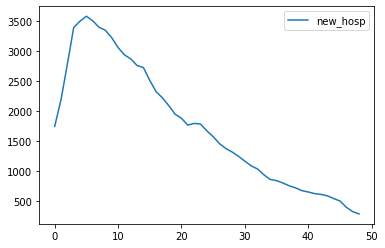

In [37]:
shifted_new_cases_df.plot()

We also cut the the last days according to `shift` in `df`:

In [38]:
n_demographies = df['demography'].nunique()
last_index = df.shape[0] - n_demographies * shift - 1

shifted_df = df.loc[:last_index,:]

In [39]:
shifted_new_cases_df = shifted_new_cases_df.loc[shifted_new_cases_df.index.repeat(n_demographies)].reset_index(drop=True)

In [40]:
shifted_df = pd.concat([shifted_df, shifted_new_cases_df], axis=1)

shifted_df.head()

,age,day,hosp,icu,recovered,death,gender,demography,new_hosp
0,0,2020-03-18,17,2,35,0,f,f_0,1741.714286
1,0,2020-03-18,23,4,39,0,h,h_0,1741.714286
2,20,2020-03-18,21,3,36,0,f,f_20,1741.714286
3,20,2020-03-18,29,6,40,1,h,h_20,1741.714286
4,30,2020-03-18,48,8,42,0,f,f_30,1741.714286


In [41]:
shifted_df.tail()

,age,day,hosp,icu,recovered,death,gender,demography,new_hosp
779,60,2020-05-06,1974,750,5453,1124,h,h_60,284.142857
780,70,2020-05-06,2596,217,4533,1496,f,f_70,284.142857
781,70,2020-05-06,2708,672,5142,2177,h,h_70,284.142857
782,80,2020-05-06,5187,49,5613,3884,f,f_80,284.142857
783,80,2020-05-06,5410,150,6365,5649,h,h_80,284.142857


Now in `shifted_df` *new_hosp* correspond to the new hospitalisations 7 days later

Now we compute the proportion for each demography of the daily current hospitalisation:

In [42]:
total_day = shifted_df.groupby(['day'])['hosp'].agg('sum').reset_index()
total_day = total_day.rename(columns={'hosp': 'total_hosp'})

shifted_df = pd.merge(shifted_df, total_day, on='day', how='left')

shifted_df['prop_hosp'] = shifted_df['hosp'] / shifted_df['total_hosp']

We assume that the proportion of new hospitalisations 7 days later in the same than the current proportion of hospitalisation for each demography:

In [43]:
shifted_df['part_new_hosp'] = shifted_df['new_hosp'] * shifted_df['prop_hosp']

Now we load the probability of hospitalisation given infected:

In [44]:
transition_df = pd.read_csv('../data/df_transitions_finale.csv')

# "infected_hosp" is the probability of getting hospitalised given infected
transition_df = transition_df.loc[:, ['demography', 'infected_hosp']]

shifted_df = pd.merge(shifted_df, transition_df, on='demography', how='left')
shifted_df['infected'] = shifted_df['part_new_hosp'] / shifted_df['infected_hosp']
shifted_df['infected'] = shifted_df['infected'].apply(lambda x: round(x))

cols_to_keep = ['day', 'demography', 'infected', 'hosp', 'icu', 'recovered', 'death']
df = shifted_df.loc[:, cols_to_keep]

df.head()

,day,demography,infected,hosp,icu,recovered,death
0,2020-03-18,f_0,11325,17,2,35,0
1,2020-03-18,h_0,13790,23,4,39,0
2,2020-03-18,f_20,2518,21,3,36,0
3,2020-03-18,h_20,2898,29,6,40,1
4,2020-03-18,f_30,3198,48,8,42,0


In [45]:
df.tail()

,day,demography,infected,hosp,icu,recovered,death
779,2020-05-06,h_60,337,1974,750,5453,1124
780,2020-05-06,f_70,388,2596,217,4533,1496
781,2020-05-06,h_70,284,2708,672,5142,2177
782,2020-05-06,f_80,390,5187,49,5613,3884
783,2020-05-06,h_80,206,5410,150,6365,5649


### Estimate the current number of asymptomatic cases by demography

We consider it takes 5 days between the contamination and the appearance of symptoms. This time we consider the probability for getting infected (symptomatic) if getting asymptomatic equals to 0.5 for all demographics.

We proceed the same way:

In [46]:
shift = 5

In [47]:
last_index = df.shape[0] - n_demographies * shift - 1
shifted_df = df.loc[:last_index,:]

In [48]:
shifted_infected = df.loc[shift * n_demographies:, ['infected']].reset_index(drop=True)
shifted_infected = shifted_infected.rename(columns={'infected': 'shifted_infected'})

shifted_df = pd.concat([shifted_df, shifted_infected], axis=1)

In [49]:
shifted_df.head()

,day,demography,infected,hosp,icu,recovered,death,shifted_infected
0,2020-03-18,f_0,11325,17,2,35,0,12562
1,2020-03-18,h_0,13790,23,4,39,0,15493
2,2020-03-18,f_20,2518,21,3,36,0,4522
3,2020-03-18,h_20,2898,29,6,40,1,5234
4,2020-03-18,f_30,3198,48,8,42,0,7072


In [50]:
p_asympinf = .1

In [51]:
shifted_df['asymptomatic'] = shifted_df['shifted_infected'] * (1 / p_asympinf)

In [52]:
cols_to_keep = ['day', 'demography', 'asymptomatic', 'infected', 'hosp', 'icu', 'recovered', 'death']
df = shifted_df.loc[:, cols_to_keep]

In [53]:
df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d')

In [54]:
df.tail()

,day,demography,asymptomatic,infected,hosp,icu,recovered,death
699,2020-05-01,h_60,3370.0,692,2122,914,5206,1060
700,2020-05-01,f_70,3880.0,803,2814,288,4154,1414
701,2020-05-01,h_70,2840.0,586,2926,816,4790,2079
702,2020-05-01,f_80,3900.0,801,5578,63,4870,3650
703,2020-05-01,h_80,2060.0,422,5798,179,5615,5364


In [55]:
df.to_csv('../data/state_repartition_demography.csv', index=False)

## Comparison with the reported number of cases

In [681]:
estimate_df = df.groupby(['day'])['asymptomatic', 'infected', 'hosp', 'icu', 'recovered', 'death'].agg('sum').reset_index()
estimate_df['estimated_total_cases'] = estimate_df.apply(lambda x: x['asymptomatic'] + x['infected'] + x['hosp'] + x['icu'], 1)



In [682]:
reported_df = pd.read_csv('../doc/owid.csv')


reported_df = reported_df.loc[reported_df['location'] == 'France', ['date', 'total_cases']].reset_index(drop=True)

reported_df = reported_df.rename(columns={'date': 'day', 'total_cases': 'reported_total_cases'})
reported_df['day'] = pd.to_datetime(reported_df['day'])

In [683]:
comparison_df = pd.merge(estimate_df, reported_df, on='day', how='left')

In [684]:
comparison_df_plot = comparison_df.loc[(comparison_df['day'] >= '2020-03-20') & (comparison_df['day'] <= '2020-04-20')]

[]

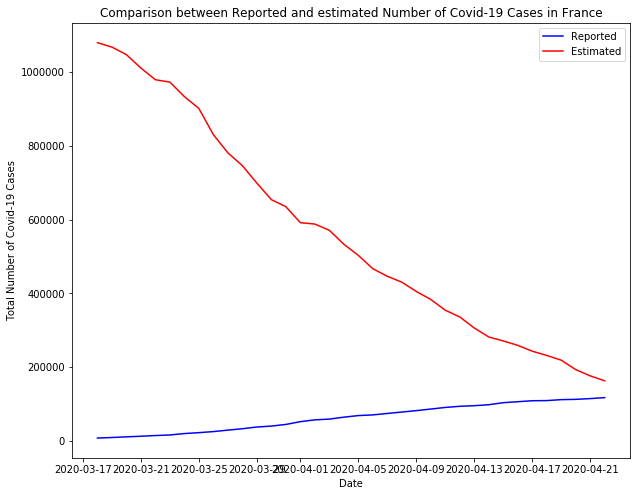

In [685]:
plt.figure(figsize=(10, 8))
plt.plot(comparison_df['day'], comparison_df['reported_total_cases'], 'b-', label = 'Reported')
plt.plot(comparison_df['day'], comparison_df['estimated_total_cases'], 'r-', label = 'Estimated')
plt.xlabel('Date')
plt.ylabel('Total Number of Covid-19 Cases')
plt.title('Comparison between Reported and estimated Number of Covid-19 Cases in France')
plt.legend()
plt.plot()

## Générer les durées courante de par état

In [715]:
repartition_df = pd.read_csv('../data/state_repartion_demography.csv')

repartition_df.head()

,day,demography,asymptomatic,infected,hosp,icu,recovered,death
0,2020-03-18,f_0,93920.0,11335,17,2,35,0
1,2020-03-18,h_0,118350.0,13802,23,4,39,0
2,2020-03-18,f_20,41250.0,2520,21,3,36,0
3,2020-03-18,h_20,48470.0,2900,29,6,40,1
4,2020-03-18,f_30,61990.0,3201,48,8,42,0


In [716]:
import numpy as np
from datetime import datetime

def get_under_params(mean, mediane):
    mu = np.log(mediane)
    sigma = np.sqrt(2 * (np.log(mean) - mu))
    return mu, sigma

def draw_lognormal(mean, mediane, n):
    mu, sigma = get_under_params(mean, mediane)
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

pop_totale = 700000

states =  ['healthy', 'asymptomatic', 'asympcont', 'infected', 'hosp', 'icu', 'death', 'recovercont', 'recovered']
states2ids = {state: i for i, state in enumerate(states)}

In [717]:
state_mm = {'asymptomatic': (6, 5), 'infected': (9, 7), 'hosp': (10, 4), 'icu': (18, 17), 'recovercont': (14, 12)}
day = datetime(2020, 4, 1)

In [719]:
df['day'] = pd.to_datetime(df['day'])

day_df = repartition_df.loc[repartition_df['day'] == date].reset_index(drop=True)

day_df

,day,demography,asymptomatic,infected,hosp,icu,recovered,death
0,2020-04-01,f_0,46380.0,5985,52,7,150,0
1,2020-04-01,h_0,57850.0,7976,77,22,157,1
2,2020-04-01,f_20,17530.0,2590,125,13,328,2
3,2020-04-01,h_20,20280.0,3246,188,38,344,2
4,2020-04-01,f_30,25440.0,3798,330,50,566,6
5,2020-04-01,h_30,26490.0,4256,493,145,596,9
6,2020-04-01,f_40,38720.0,5753,722,126,775,17
7,2020-04-01,h_40,43680.0,6999,1081,366,815,28
8,2020-04-01,f_50,41790.0,6207,1498,333,1010,64
9,2020-04-01,h_50,45380.0,7254,2241,972,1062,104


In [720]:
demography_state_duration = {}

for _, row in day_df.iterrows():
    current_state_ids, current_state_durations = np.array([]), np.array([])
    demography = row['demography']
    for state in states:
        if state not in row:
            continue
        state_id = states2ids.get(state)
        n_state = int(row[state] * pop_totale / 67000000)
        current_state_ids = np.append(current_state_ids, np.ones(n_state) * state_id)
        if state in ['recovered', 'death']:
            state_durations = np.ones(n_state) * -1
            current_state_durations = np.append(current_state_durations, state_durations)
            continue            
        mean, mediane = state_mm.get(state)
        state_durations = draw_lognormal(mean, mediane, n_state)
        current_state_durations = np.append(current_state_durations, state_durations)
    current_state_durations = np.around(current_state_durations).astype(np.uint32)
    demography_state_duration[demography] = {'state_ids': current_state_ids, 'state_durations': current_state_durations}
    

demography_state_duration        
        

{'f_0': {'state_ids': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

In [698]:
draw_lognormal(3, 2, 10)

array([1.90655208, 0.45541264, 1.09350718, 3.36979702, 0.88818941,
       0.87602648, 0.79930989, 0.58666902, 1.21855785, 0.43025799])

In [703]:
states2ids

{'healthy': 0,
 'asymptomatic': 1,
 'asympcont': 2,
 'infected': 3,
 'hosp': 4,
 'icu': 5,
 'death': 6,
 'recovercont': 7,
 'recovered': 8}

In [714]:
demography_state_duration['h_50']['state_durations'].shape[0]

594

In [ ]:
imperial_df = pd.read_csv('../doc/estimates-imperial-college.csv')

imperial_df = imperial_df.loc[imperial_df['country'] == 'France', ['time', 'predicted_infections_mean_cumulative']].reset_index(drop=True)

imperial_df['time'] = pd.to_datetime(imperial_df['time'])
imperial_df.set_index('time', inplace=True)

imperial_df.plot()
plt.show()

NameError: name 'pd' is not defined

[]

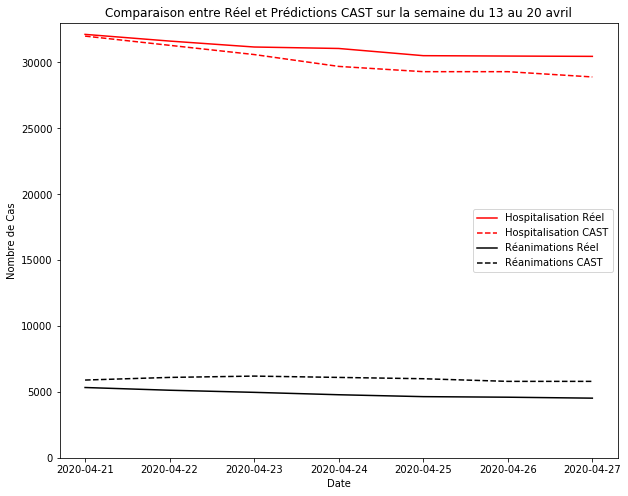

In [12]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from numpy import array

day = datetime(2020, 4, 21)
days = [day + timedelta(i) for i in range(7)]

hosp_real = array([32131, 31623, 31172, 31061, 30515, 30486, 30462])
hosp_cast = array([32000, 31300, 30600, 29700, 29300, 29300, 28900])
array([6599, 6331, 6139, 5922, 5733, 5644, 5584])
rea_cast = array([5900, 6100, 6200, 6100, 6000, 5800, 5800])


plt.figure(figsize=(10, 8))
plt.plot(days, hosp_real, 'r-', label = 'Hospitalisation Réel')
plt.plot(days, hosp_cast, 'r--', label = 'Hospitalisation CAST')
plt.plot(days, rea_real, 'k-', label = 'Réanimations Réel')
plt.plot(days, rea_cast, 'k--', label = 'Réanimations CAST')
plt.xlabel('Date')
plt.ylabel('Nombre de Cas')

plt.ylim([0, 33000])
plt.title('Comparaison entre Réel et Prédictions CAST sur la semaine du 13 au 20 avril')
plt.legend()
plt.plot()

In [19]:
import numpy as np

params = np.load('../calibrations/0.npy')

In [20]:
params

array({'score': {'hosp': {'err': 4.71641158527172, 'real': array([29984, 29627, 29113, 28554, 28119, 28114, 27954, 27607, 26736,
       26192, 25809, 25751, 25739, 25472, 24701, 23912, 23139]), 'estimated': array([30100, 29700, 29600, 29100, 28600, 28400, 28100, 28000, 27800,
       27400, 27400, 27300, 27200, 27100, 27100, 27000, 26800])}, 'icu': {'err': 4.4232304613611095, 'real': array([5334, 5127, 4967, 4785, 4641, 4598, 4526, 4392, 4128, 3947, 3819,
       3770, 3762, 3639, 3375, 3095, 2911]), 'estimated': array([5100, 5000, 4800, 4800, 4800, 4600, 4600, 4600, 4300, 4300, 4200,
       4100, 3700, 3600, 3500, 3300, 3200])}}, 'params': {'cell_ids': array([     0,      1,      2, ..., 328178, 328179, 328180], dtype=uint32), 'attractivities': array([ 0.        ,  0.        ,  0.        , ..., -0.01029916,
        0.3830058 , -0.09146073]), 'unsafeties': array([1.        , 1.        , 1.        , ..., 0.35659619, 0.20569509,
       0.21822717]), 'xcoords': array([63.59267488, 61.770695

In [50]:
csi_path = '../propagsim/np/maps/week1/current_state_ids.npy'
csd_path = '../propagsim/np/maps/week1/current_state_durations.npy'

current_state_ids = np.load(csi_path).flatten()
current_state_durations = np.load(csd_path).flatten()

In [56]:
current_state_ids[current_state_ids==5].shape[0]

30

In [57]:
pos_icu = np.where(current_state_ids==5)[0]

In [58]:
switch = pos_icu[:43]

In [59]:
current_state_ids[switch] = 8
current_state_durations[switch] = -1

In [60]:
current_state_ids[current_state_ids==5].shape[0]

27

In [61]:
np.save(csi_path, current_state_ids)
np.save(csd_path, current_state_durations)

=========================

In [133]:
res_same = {0: {0: 696371, 1: 1314, 2: 28, 3: 157, 4: 222, 5: 27, 6: 130, 7: 45, 8: 773},
 1: {0: 696364, 1: 1313, 2: 29, 3: 156, 4: 221, 5: 25, 6: 130, 7: 46, 8: 783},
 2: {0: 696359, 1: 1311, 2: 29, 3: 155, 4: 221, 5: 24, 6: 131, 7: 44, 8: 793},
 3: {0: 696357, 1: 1310, 2: 30, 3: 155, 4: 221, 5: 23, 6: 131, 7: 31, 8: 809},
 4: {0: 696356, 1: 1303, 2: 31, 3: 155, 4: 221, 5: 23, 6: 131, 7: 26, 8: 821},
 5: {0: 696355, 1: 1298, 2: 32, 3: 155, 4: 221, 5: 23, 6: 131, 7: 26, 8: 826},
 6: {0: 696354, 1: 1297, 2: 32, 3: 155, 4: 220, 5: 21, 6: 131, 7: 23, 8: 834},
 7: {0: 696349, 1: 1301, 2: 32, 3: 155, 4: 220, 5: 21, 6: 131, 7: 18, 8: 840},
 8: {0: 696347, 1: 1296, 2: 32, 3: 154, 4: 220, 5: 19, 6: 132, 7: 19, 8: 848},
 9: {0: 696345, 1: 1295, 2: 32, 3: 154, 4: 220, 5: 19, 6: 132, 7: 19, 8: 851},
 10: {0: 696339, 1: 1298, 2: 32, 3: 154, 4: 220, 5: 18, 6: 132, 7: 15, 8: 859},
 11: {0: 696334, 1: 1298, 2: 33, 3: 154, 4: 220, 5: 16, 6: 132, 7: 15, 8: 865},
 12: {0: 696334, 1: 1296, 2: 34, 3: 154, 4: 220, 5: 16, 6: 132, 7: 12, 8: 869},
 13: {0: 696334, 1: 1291, 2: 35, 3: 154, 4: 220, 5: 16, 6: 132, 7: 9, 8: 876},
 14: {0: 696332, 1: 1288, 2: 35, 3: 154, 4: 220, 5: 15, 6: 132, 7: 13, 8: 878},
 15: {0: 696330, 1: 1288, 2: 35, 3: 154, 4: 220, 5: 15, 6: 132, 7: 13, 8: 880},
 16: {0: 696328, 1: 1289, 2: 35, 3: 154, 4: 220, 5: 15, 6: 132, 7: 11, 8: 883},
 17: {0: 696326, 1: 1286, 2: 36, 3: 154, 4: 220, 5: 15, 6: 132, 7: 9, 8: 889},
 18: {0: 696324, 1: 1285, 2: 37, 3: 154, 4: 220, 5: 15, 6: 132, 7: 9, 8: 891},
 19: {0: 696321, 1: 1287, 2: 37, 3: 154, 4: 220, 5: 15, 6: 132, 7: 6, 8: 895}}

In [134]:
n_hosps, n_icus = [], []
for k, v in res_same.items():
    n_hosp, n_icu = v[4], v[5]
    n_hosps.append(n_hosp)
    n_icus.append(n_icu)
    

In [135]:
n_hosps, n_icus = np.array(n_hosps), np.array(n_icus)

In [136]:
n_icus = 100 * n_icus
n_hosps = 100 * n_hosps

In [139]:
n_hosps

array([22200, 22100, 22100, 22100, 22100, 22100, 22000, 22000, 22000,
       22000, 22000, 22000, 22000, 22000, 22000, 22000, 22000, 22000,
       22000, 22000])

In [137]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from numpy import array

day = datetime(2020, 5, 11)
days = [day + timedelta(i) for i in range(20)]

[]

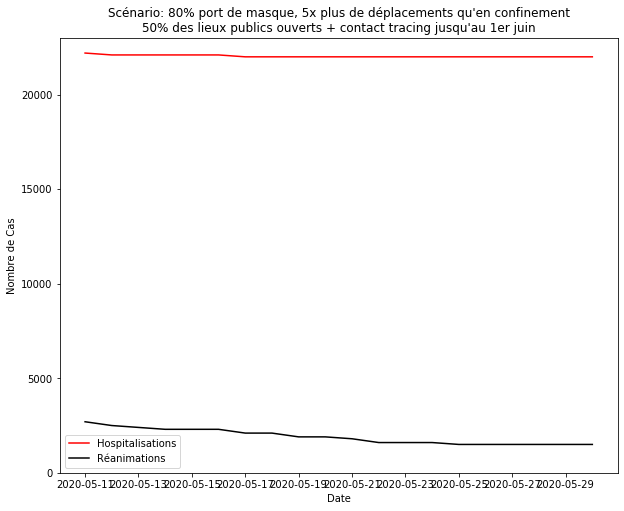

In [140]:
plt.figure(figsize=(10, 8))
plt.plot(days, n_hosps, 'r-', label = 'Hospitalisations')
plt.plot(days, n_icus, 'k-', label = 'Réanimations')
plt.xlabel('Date')
plt.ylabel('Nombre de Cas')

plt.ylim([0, 23000])
plt.title("Scénario: 80% port de masque, 5x plus de déplacements qu'en confinement\n50% des lieux publics ouverts + contact tracing jusqu'au 1er juin")
plt.legend()
plt.plot()